# Signal to Noise Ratio

In any pattern recognition problem, we are trying to recognize the presence of particular patterns of interest, and distinguish them from other patterns of interest and patterns not of interest. By definition, in any pattern recognition problem, we will always need to contend with patterns that we are interested in to achieve our goals, and patterns that we are not interested in which distract from our goals. Unfortunately, nature is unpredictable and not always sympathetic to our goals, and patterns are subject to vary from occurrence to occurrence and vary in the time at which they occur and duration for which they occur. This is true both for patterns of interest and for patterns that distract us. Since both vary from occurrence to occurrence, some instances will be easier to distinguish than others. Since both vary in their times of occurrence, distracting patterns are likely to occur simultaneously with patterns of interest on some occasions.

In the field of *signal and image processing*, patterns we are interested in are called signals, and patterns we are not interested in are called noise. While we often think of noise as a static distribution (e.g., Gaussian noise) in trivial problems, in *practical* signal and image processing performed on real world data, noise can be any pattern that we are not interested in detecting, classifying, or acting on. While this is not explicitly a course on signal and image processing, having an understanding signals and noise from the viewpoint of signal and image processing will help us produce more robust machine learning models.

At any given time, there will be some mix of both signals and noise present in our data. We can say that the data received, $x_{R}$ is equal to the sum of the signal $x_{S}$ and the noise $x_{N}$,

$$
x_R = x_S + x_N.
$$

When specifying the performance of our models, we need a metric which helps us quantify their performance as the amount of distracting noise increases. That metric is the signal-to-noise ratio (SNR).

Without using any math, we can define SNR intuitively to start.

$$
\mathrm{SNR} = \frac{\mathrm{Amount\ of\ Signal\ in\ Data}}{\mathrm{Amount\ of\ Noise\ in\ Data}}
$$

As we get more signal, $X_S$, SNR increases. As we get more noise, $X_N$, SNR decreases.

But what quantifies "more" signal or more noise? How do we formally define the "amount" of signal or noise?

In the most basic definition, we use power. A more formal definition of SNR in terms of power in the signal and power in the noise is given by

$$
\mathrm{SNR} = P(x_S) / P(x_N)
$$

Here $P$ is the power of the signal,

$$
P(x) = \frac{1}{N} \sum_{n=1}^N x^2[n].
$$

Notice that this is really just quantifying (formally) what we mean when we say "more" signal. When the values of the signal get larger in either the positive or negative direction, their squares will get larger. The more large values there are, the larger the sum will be.

For a zero-mean Gaussian $x$, this is equivalent to the variance, $\mathrm{Var}[x] = \sigma^2$. While this fact is often exploited in toy problems, as we will see, the noise is almost never Gaussian in practice.

In practice, the noise can:
* take on a non-Gaussian distribution, especially a distribution skewed by physical or algorithmic processes which introduce bias,
* be non-stationary, with mean, variance, and higher order moments changing with respect to time,
* look similar to patterns of interest (not all noise needs to be completely random!),
* contain multiple mixed random and non-random components.

Further, in practice we will use different variations of the SNR definition for different applications, and see that each has some benefits and tradeoff.

In this notebook we will get some intuition for SNR by looking at some fundamental examples.

Discussion: Intuition

* Audio
* Images
* Sports

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SNR Units: Quick Look at Decibels

SNR is a ratio, so it is usually measured on a logarithmic scale in decibels (dB).

The formula for converting from SNR as a ratio to SNR in dB is

$$
\mathrm{SNR}_{\mathrm{dB}} = 10\ \mathrm{log_{10}}(\mathrm{SNR}_{\mathrm{RATIO}}).
$$

Here we can see how the logarithmic scale compares to the linear scale.

Text(0.5, 1.0, 'SNR in dB vs. SNR as a Ratio')

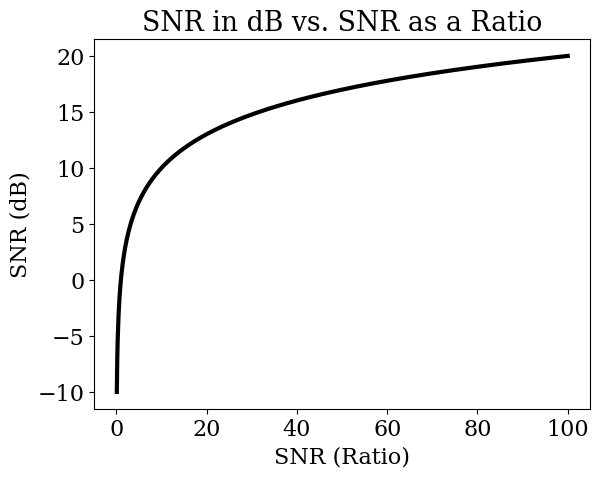

In [19]:
snr_ratio = np.linspace(0.1, 100, 1000)
snr_db = 10 * np.log10(snr_ratio)

plt.figure()
plt.plot(snr_ratio, snr_db, linewidth=3, color="k")
plt.xlabel("SNR (Ratio)")
plt.ylabel("SNR (dB)")
plt.title("SNR in dB vs. SNR as a Ratio")

Why is it convenient to consider SNR in dB?

There are many physical and psychological reasons, including the fact that human perception closely approximate a logarithmic scale ([https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law](https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law)).

For analyzing the performance of algorithms, as we will see, considering SNR on a dB scale better shows performance trends.

Many algorithms will exhibit a performance that approximates

$$
\mathrm{Accuracy} = \mathrm{tanh}(\mathrm{SNR}_{\mathrm{dB}}),
$$

i.e., they will be accurate for high SNRs, then slowly degrade for lower SNRs along a curve.

However, plotting such curves on a linear scale makes it difficult to see the breakdown point and performance roll off clearly.

$$
\mathrm{Accuracy} = \mathrm{tanh}(\mathrm{10\ log}_{10}(\mathrm{SNR}_{\mathrm{RATIO}}))
$$

does not look as clean when plotted.

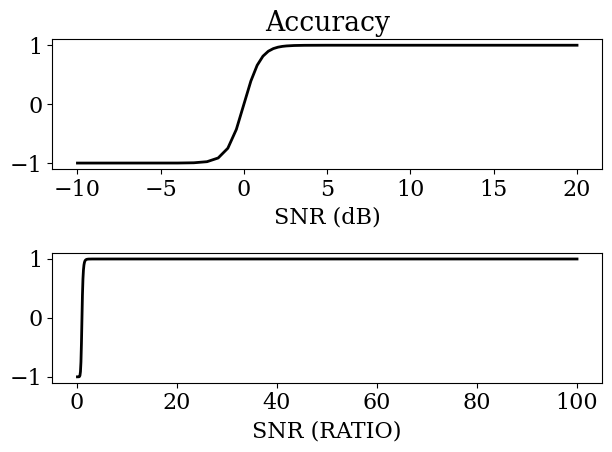

In [20]:
dummy_accuracy_wrt_snr = np.tanh(snr_db)

fig, ax = plt.subplots(2, 1)
ax[0].plot(snr_db, dummy_accuracy_wrt_snr, linewidth=2, color="k")
ax[0].set_xlabel("SNR (dB)")
ax[1].plot(snr_ratio, dummy_accuracy_wrt_snr, linewidth=2, color="k")
ax[1].set_xlabel("SNR (RATIO)")
ax[0].set_title("Accuracy")
fig.tight_layout()

## Fundamental Example: Detecting a Pattern in Noise

Here we'll consider a fundamental example. We'll generate a simple dataset and explore how well two different classifiers can separate the data in the presence of noise.

Along the way, we'll use some tricks with `pandas` and `seaborn` to help interpret the results.

We start by generating a tabular dataset where we must classify two binary numbers by their digits.

In [21]:
def generate_dataset(n_samples_per_class):
    pattern_of_interest_1 = np.array([0, 0, 1, 0, 1, 0, 1, 0])  # 42
    pattern_of_interest_2 = np.array([0, 0, 0, 0, 1, 1, 0, 1])  # 13

    x_features_1 = np.tile(pattern_of_interest_1, (n_samples_per_class, 1))
    x_features_2 = np.tile(pattern_of_interest_2, (n_samples_per_class, 1))

    x_features = np.vstack((x_features_1, x_features_2))
    y_labels = np.array([0] * n_samples_per_class + [1] * n_samples_per_class)

    return x_features, y_labels


x_features, y_labels = generate_dataset(n_samples_per_class=100)

Using `torch` is overkill for this problem so we import `scikit-learn` to use for ML, alongside `pandas` for DataFrame manipulation and `seaborn` for plotting.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd

`scikit-learn` makes it easy to formulate a train-test split.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    x_features, y_labels, test_size=0.2, random_state=42
)

We will create and train two classifiers, a Random Forest and a Support Vector Machine (SVM) to fit our problem.

In [24]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(kernel="linear", random_state=42)
rf_classifier.fit(x_train, y_train)
svm_classifier.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

Both classifiers perform well on the test set with no noise.

In [25]:
y_inferred_rf = rf_classifier.predict(x_test)
y_inferred_svm = svm_classifier.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_inferred_rf)
accuracy_svm = accuracy_score(y_test, y_inferred_svm)

print(f"Random Forest accuracy: {accuracy_rf * 100:.2f}%")
print(f"SVM accuracy: {accuracy_svm * 100:.2f}%")

Random Forest accuracy: 100.00%
SVM accuracy: 100.00%


Now we'll add noise to the test data that was not present in the training set, and see how each classifier performs.

In [26]:
def add_gaussian_noise(x_features, std=0.1):
    noise = np.random.normal(0, std, x_features.shape)
    x_noisy_features = x_features + noise
    return x_noisy_features


x_test_noisy = add_gaussian_noise(x_test, std=1)

Even with small amounts of noise, we can already see the SVM outperforming the random forest.

In [27]:
y_inferred_noisy_rf = rf_classifier.predict(x_test_noisy)
accuracy_noisy_rf = accuracy_score(y_test, y_inferred_noisy_rf)

y_inferred_noisy_svm = svm_classifier.predict(x_test_noisy)
accuracy_noisy_svm = accuracy_score(y_test, y_inferred_noisy_svm)

print(f"Random Forest accuracy with noise: {accuracy_noisy_rf * 100:.2f}%")
print(f"SVM accuracy with noise: {accuracy_noisy_svm * 100:.2f}%")

Random Forest accuracy with noise: 85.00%
SVM accuracy with noise: 87.50%


Having a benchmark at a single noise level helps, however, the experiment is stochastic, so the values will be slightly different (and sometimes very different) each trial.

What we would prefer to see is the distribution of accuracy across several trials, and then to see how that distribution changes as the parameters of the noise distribution change.

To do that, we create a loop which iterates over several trials, and then for each trial iterates over a range of noise levels and
* adds noise to the test data,
* scores both classifiers,
* computes the SNR that experiment trial was conducted at,
* saves the result to a dictionary to be converted to a DataFrame later.


In [28]:
sigma_values = np.arange(0.1, 7, 0.2)
accuracy_noisy_rf_values = np.zeros(sigma_values.shape)
n_repeats = 50

accuracies = []


def compute_snr_db(x_test_noisy, epsilon=1e-7):
    noise = x_test_noisy - x_test
    mean_square_noise = np.mean(noise**2)
    mean_square_signal = np.mean(x_test**2)
    snr = mean_square_signal / (mean_square_noise + epsilon)
    snr_db = 10 * np.log10(snr)
    return snr_db


def score_classifiers(x_test_noisy, rf_classifier, svm_classifier):
    y_inferred_noisy_rf = rf_classifier.predict(x_test_noisy)
    y_inferred_noisy_svm = svm_classifier.predict(x_test_noisy)
    accuracy_noisy_rf = accuracy_score(y_test, y_inferred_noisy_rf)
    accuracy_noisy_svm = accuracy_score(y_test, y_inferred_noisy_svm)
    return accuracy_noisy_rf, accuracy_noisy_svm


def append_to_dictionary(
    accuracies, sigma, accuracy_noisy_rf, accuracy_noisy_svm, snr_db
):
    accuracies.append(
        {
            "Model": "RF",
            "Sigma": sigma,
            "SNR (dB)": snr_db,
            "Accuracy": accuracy_noisy_rf,
        }
    )
    accuracies.append(
        {
            "Model": "SVM",
            "Sigma": sigma,
            "SNR (dB)": snr_db,
            "Accuracy": accuracy_noisy_svm,
        }
    )


for _ in range(n_repeats):
    for sigma in sigma_values:
        x_test_noisy = add_gaussian_noise(x_test, std=sigma)
        accuracy_noisy_rf, accuracy_noisy_svm = score_classifiers(
            x_test_noisy, rf_classifier, svm_classifier
        )
        snr_db = compute_snr_db(x_test_noisy)
        append_to_dictionary(
            accuracies, sigma, accuracy_noisy_rf, accuracy_noisy_svm, snr_db
        )

Now we can start by using `sns.boxplot` to see how the performance of each model varies with respect to standard deviation of the added noise.

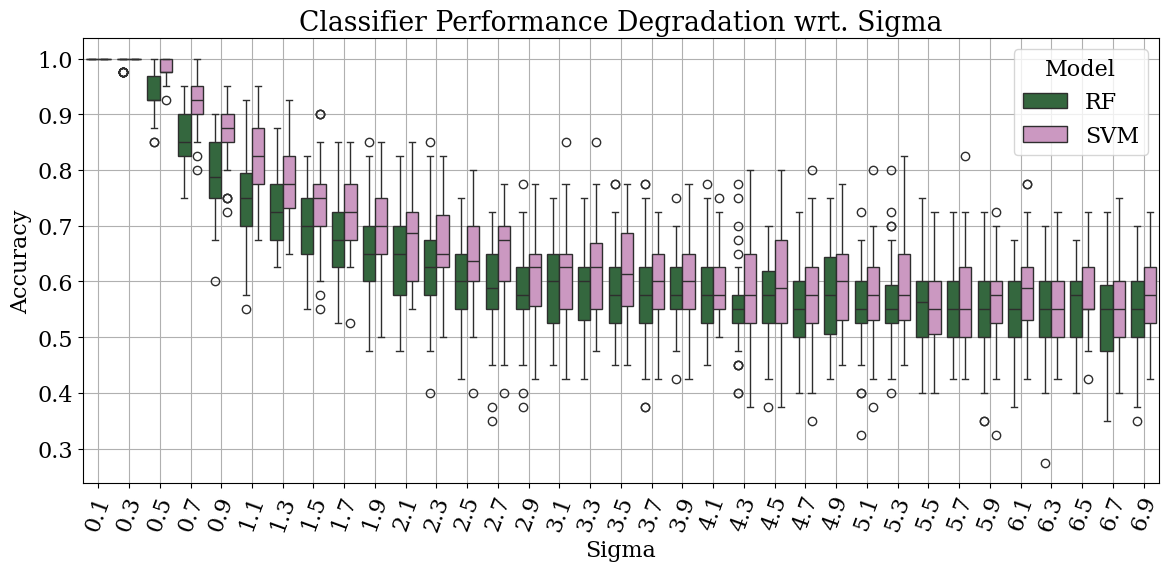

In [29]:
df = pd.DataFrame(accuracies)

plt.figure(figsize=(12, 6))
sns.boxplot(x="Sigma", y="Accuracy", hue="Model", data=df, palette="cubehelix")
locs, labels = plt.xticks()
xtick_labels = ["{:.1f}".format(sigma) for sigma in sigma_values]
plt.xticks(locs, xtick_labels, rotation=70)
plt.title("Classifier Performance Degradation wrt. Sigma")
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

Although both classifiers have some robustness, the SVM clearly out-performs the random forest in most cases.

The variance in performance, especially at low SNRs, highlights why we need to perform repeated trials (to avoid taking an outlier result where the classifier with lower probability of achieving high accuracy was more accurate as representative of the entire distribution of accuracies).

Seeing the results with respect to variance is nice, but as we will see it will be more intuitive to plot them with respect to SNR in dB. We have SNR in dB already, but we will need to do some work with pandas to get the plot looking right.

Let's start with a scatter plot.

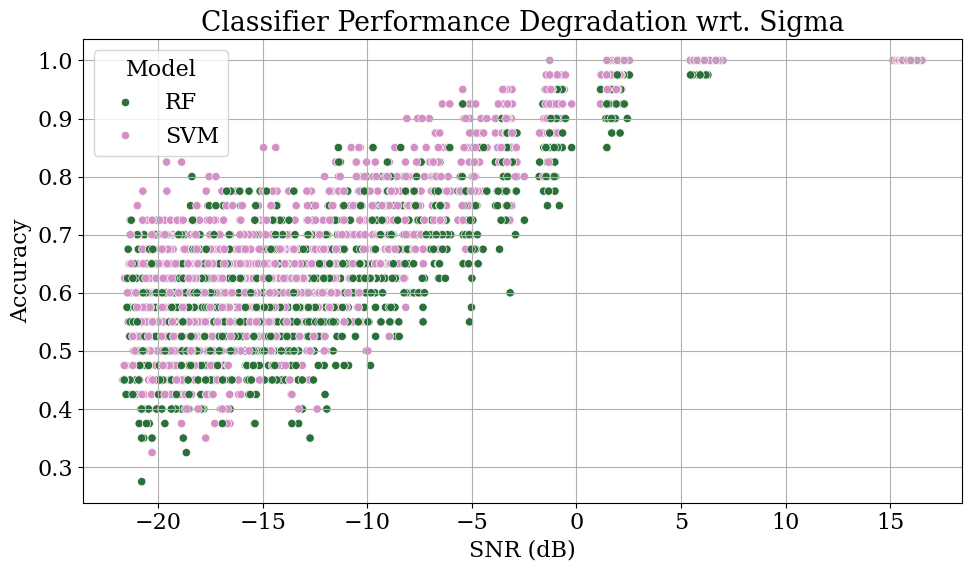

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="SNR (dB)", y="Accuracy", hue="Model", data=df, palette="cubehelix"
)
plt.title("Classifier Performance Degradation wrt. Sigma")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

We can clearly see the trend: SVM is more robust than Random Forest for this problem. The scatter plot is difficult to interpret in the overlapped region though.

What we are really looking at is a two dimensional distribution, i.e., the frequency of observing different accuracy-SNR pairs for each model. We desire a model with a high frequency of high-accuracy and low-SNR pairs.

We can try to see that more clearly with a KDE plot.

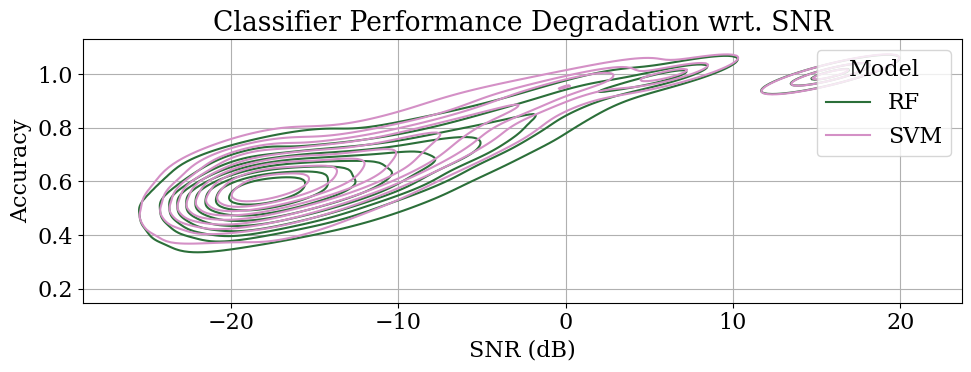

In [31]:
plt.figure(figsize=(10, 4))
sns.kdeplot(
    x="SNR (dB)", y="Accuracy", hue="Model", data=df, palette="cubehelix"
)
plt.title("Classifier Performance Degradation wrt. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

This is cleaner, but we can still do better. What we really want is easy to interpret curves that show model performance varying with respect to more and more challenging conditions, clearly showing the failure point and the benefits of one model over the other.

To get this, we'll do some data manipulation. First, we need to bin our SNR values so we have discrete SNR categories (think "low" vs. "medium" vs. "high") we can compute average accuracy within across our trials. We can do this using `pd.cut`.

Once we have our discrete variables, we will `groupby` them and the Model column to get the mean SNR and mean accuracy across all trials, per model, within each SNR bin.

Finally, we sort the DataFrame by mean SNR within a bin so it will be easier to plot trends across SNR.

**Note:** the `observed` bool defaults to False, but will default to True in future pandas versions.

The `observed` bool controls how categorical groupers are handled:

```text
If True: only show observed values for categorical groupers. If False: show all values for categorical groupers.

Deprecated since version 2.1.0: The default value will change to True in a future version of pandas
```

In [32]:
n_bins = 20
df["SNR (dB) Binned"] = pd.cut(df["SNR (dB)"], n_bins)
df["SNR (dB) Mean"] = df.groupby(["SNR (dB) Binned", "Model"], observed=True)[
    "SNR (dB)"
].transform("mean")
df["Accuracy Mean"] = df.groupby(["SNR (dB) Binned", "Model"], observed=True)[
    "Accuracy"
].transform("mean")

df.sort_values(by="SNR (dB) Mean", inplace=True)

Now with these manipulations, we can get smooth average accuracy curves, showing each model's average accuracy across all trials, for SNRs near the mean SNR on the x-axis. This gives us an approximate accuracy vs. SNR curve that allows us to characterize the failure point of each model and quantify the robustness gained by the better model (in this case, the SVM).

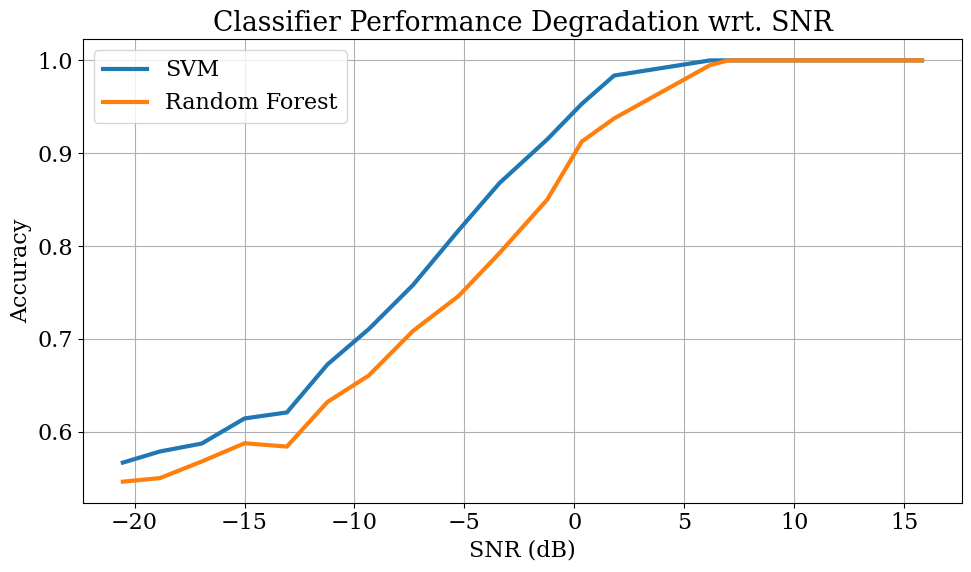

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(
    df[df["Model"] == "SVM"]["SNR (dB) Mean"],
    df[df["Model"] == "SVM"]["Accuracy Mean"],
    linewidth="3",
)
plt.plot(
    df[df["Model"] == "RF"]["SNR (dB) Mean"],
    df[df["Model"] == "RF"]["Accuracy Mean"],
    linewidth="3",
)
plt.title("Classifier Performance Degradation wrt. SNR")
plt.legend(("SVM", "Random Forest"))
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

As a final step, we can use a box-plot to see the distribution of accuracy for each model within each SNR bin.

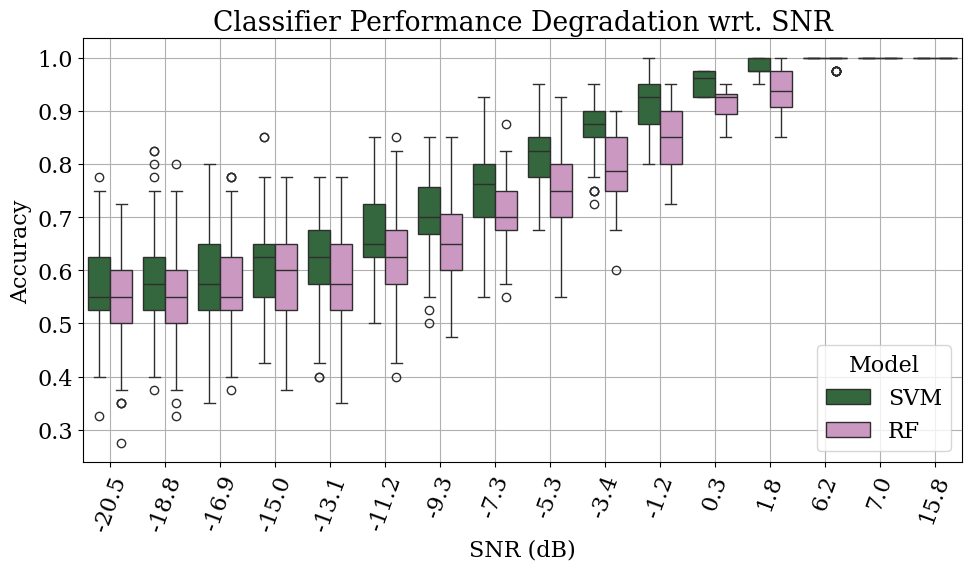

In [34]:
df.sort_values(by="SNR (dB) Mean", inplace=True)
snr_mean_db_values = df["SNR (dB) Mean"].unique()

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="SNR (dB) Mean", y="Accuracy", hue="Model", data=df, palette="cubehelix"
)
locs, labels = plt.xticks()
xtick_labels = [
    "{:.1f}".format(snr_mean_db) for snr_mean_db in snr_mean_db_values
]
plt.xticks(locs, xtick_labels, rotation=70)
plt.title("Classifier Performance Degradation wrt. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Discussion: Defenses Against Noise

There are many ways to improve performance against noise once we have established a benchmark. We'll discuss a few of these now, and discuss them more in our upcoming class on robustness.

* Data augmentation (training on noisy data)
* Model architectures
* Exploiting prior knowledge
* Eliminate redundant features
* Occam's razor - focus on the narrowest task
* Filtering
* Nonlinearity
* Drift detection
* Regularization
* Sanitization